## Project for ECE 556, topic: SNN for detecting static object

In [ ]:
pip install spikingjelly

In [ ]:
pip install torchsummary

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from spikingjelly.clock_driven import neuron, functional, surrogate
from torch.utils.data import DataLoader

## Experiment 1: Building a SNN model to see its performance

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [3]:
class SNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.lif1 = neuron.LIFNode(surrogate_function=surrogate.Sigmoid())
        self.fc2 = nn.Linear(128, 10)
        self.lif2 = neuron.LIFNode(surrogate_function=surrogate.Sigmoid())

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.lif1(x)
        x = self.fc2(x)
        x = self.lif2(x)
        return x

In [4]:
def train(epoch):
    model.train()
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        functional.reset_net(model) 
        epoch_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f}')
    train_losses.append(epoch_loss / len(train_loader))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            functional.reset_net(model)
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_accuracies.append(accuracy)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')


In [13]:
from torchsummary import summary

model = SNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

#model = SNN().to(device)
summary(model, (1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
           Sigmoid-2                  [-1, 128]               0
           LIFNode-3                  [-1, 128]               0
            Linear-4                   [-1, 10]           1,290
           Sigmoid-5                   [-1, 10]               0
           LIFNode-6                   [-1, 10]               0
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.39
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


In [8]:
train_losses = []
test_accuracies = []

for epoch in range(1, 20):
    train(epoch)
    test()

Train Epoch: 1 [0/60000] Loss: 2.302585
Train Epoch: 1 [6400/60000] Loss: 1.629962
Train Epoch: 1 [12800/60000] Loss: 1.594585
Train Epoch: 1 [19200/60000] Loss: 1.540095
Train Epoch: 1 [25600/60000] Loss: 1.496017
Train Epoch: 1 [32000/60000] Loss: 1.547168
Train Epoch: 1 [38400/60000] Loss: 1.537597
Train Epoch: 1 [44800/60000] Loss: 1.520194
Train Epoch: 1 [51200/60000] Loss: 1.511642
Train Epoch: 1 [57600/60000] Loss: 1.603254

Test set: Average loss: 0.0015, Accuracy: 9015/10000 (90.15%)

Train Epoch: 2 [0/60000] Loss: 1.509504
Train Epoch: 2 [6400/60000] Loss: 1.480392
Train Epoch: 2 [12800/60000] Loss: 1.538358
Train Epoch: 2 [19200/60000] Loss: 1.576280
Train Epoch: 2 [25600/60000] Loss: 1.473978
Train Epoch: 2 [32000/60000] Loss: 1.500035
Train Epoch: 2 [38400/60000] Loss: 1.526670
Train Epoch: 2 [44800/60000] Loss: 1.509504
Train Epoch: 2 [51200/60000] Loss: 1.482850
Train Epoch: 2 [57600/60000] Loss: 1.517716

Test set: Average loss: 0.0015, Accuracy: 9206/10000 (92.06%)

Tr

### The highest accuracy we got is 95.85%

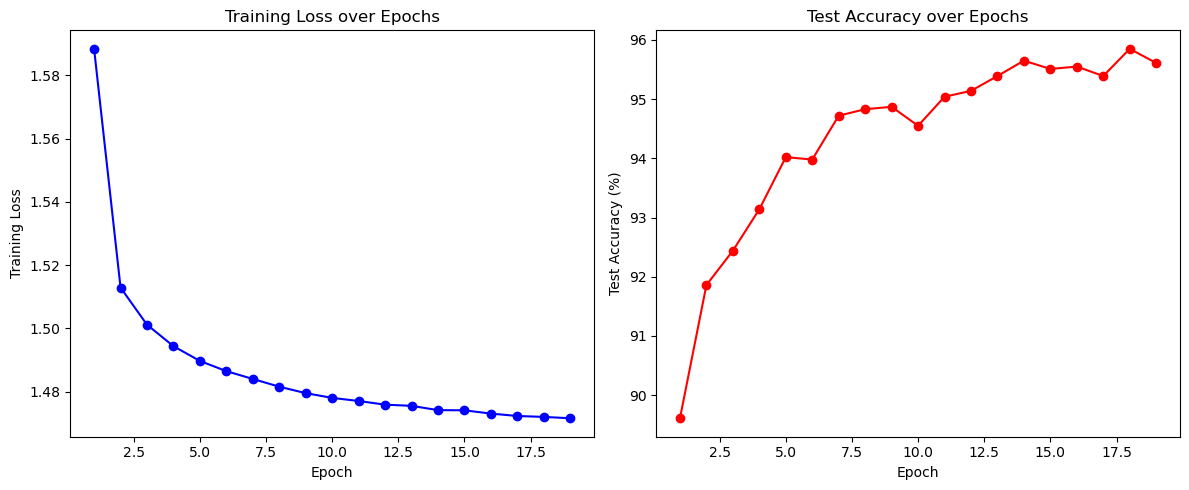

In [14]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 20), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(1, 20), test_accuracies, marker='o', linestyle='-', color='r')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy over Epochs')

plt.tight_layout()
plt.show()

## Experiment 2: evaluate our model after adding image augmentation on the MNIST data set

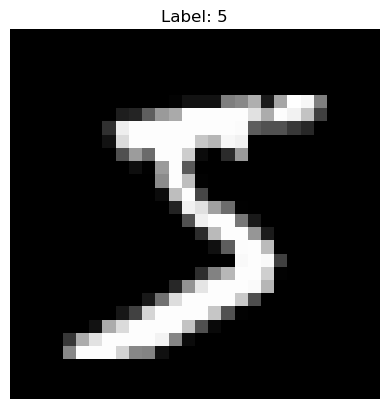

In [9]:
first_image, first_label = train_dataset[0]

plt.imshow(first_image.squeeze(), cmap="gray")
plt.title(f"Label: {first_label}")
plt.axis("off")
plt.show()

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.RandomRotation(10),  
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

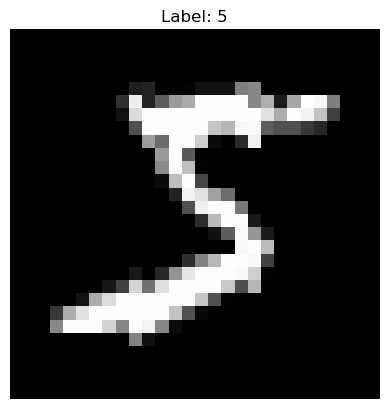

In [11]:
first_image, first_label = train_dataset[0]


plt.imshow(first_image.squeeze(), cmap="gray")
plt.title(f"Label: {first_label}")
plt.axis("off")
plt.show()

In [5]:
class SNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.lif1 = neuron.LIFNode(surrogate_function=surrogate.Sigmoid())
        self.fc2 = nn.Linear(128, 10)
        self.lif2 = neuron.LIFNode(surrogate_function=surrogate.Sigmoid())

    def forward(self, x):
        x = x.view(x.size(0), -1) 
        x = self.fc1(x)
        x = self.lif1(x)
        x = self.fc2(x)
        x = self.lif2(x)
        return x

model = SNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
test_accuracies = []

def train(epoch):
    model.train()
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        functional.reset_net(model)  
        epoch_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f}')
    train_losses.append(epoch_loss / len(train_loader))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            functional.reset_net(model)
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_accuracies.append(accuracy)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')

for epoch in range(1, 20):
    train(epoch)
    test()



Train Epoch: 1 [0/60000] Loss: 2.302585
Train Epoch: 1 [6400/60000] Loss: 1.930099
Train Epoch: 1 [12800/60000] Loss: 1.760344
Train Epoch: 1 [19200/60000] Loss: 1.714134
Train Epoch: 1 [25600/60000] Loss: 1.746098
Train Epoch: 1 [32000/60000] Loss: 1.710233
Train Epoch: 1 [38400/60000] Loss: 1.701224
Train Epoch: 1 [44800/60000] Loss: 1.667716
Train Epoch: 1 [51200/60000] Loss: 1.725292
Train Epoch: 1 [57600/60000] Loss: 1.582998

Test set: Average loss: 0.0016, Accuracy: 7949/10000 (79.49%)

Train Epoch: 2 [0/60000] Loss: 1.633376
Train Epoch: 2 [6400/60000] Loss: 1.687948
Train Epoch: 2 [12800/60000] Loss: 1.644066
Train Epoch: 2 [19200/60000] Loss: 1.582998
Train Epoch: 2 [25600/60000] Loss: 1.658212
Train Epoch: 2 [32000/60000] Loss: 1.610034
Train Epoch: 2 [38400/60000] Loss: 1.580602
Train Epoch: 2 [44800/60000] Loss: 1.559325
Train Epoch: 2 [51200/60000] Loss: 1.585178
Train Epoch: 2 [57600/60000] Loss: 1.563525

Test set: Average loss: 0.0015, Accuracy: 8458/10000 (84.58%)

Tr

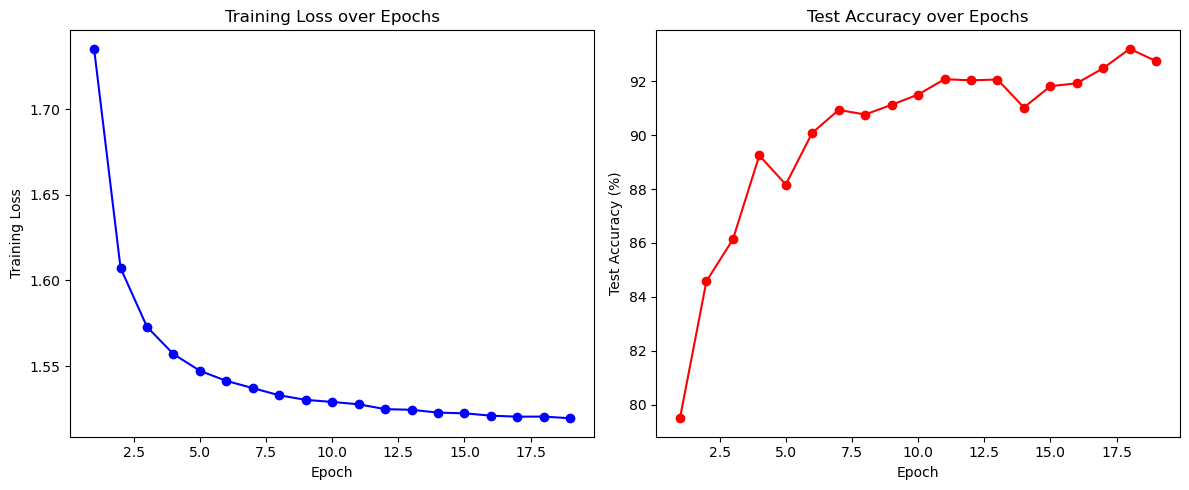

In [6]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 20), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(1, 20), test_accuracies, marker='o', linestyle='-', color='r')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy over Epochs')

plt.tight_layout()
plt.show()

### After adding the image augmentation, the highest accuracy we got is 93.21%

## Experiment 3: add adversarial attacks and see its performance

In [11]:
def fgsm_attack(model, data, target, epsilon):
    data.requires_grad = True
    output = model(data)
    loss = criterion(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    perturbed_data = data + epsilon * data_grad.sign()
    return perturbed_data.detach()

def test_adversarial(epsilon):
    model.eval()
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        perturbed_data = fgsm_attack(model, data, target, epsilon)
        output = model(perturbed_data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        functional.reset_net(model)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Adversarial Test (epsilon={epsilon}): Accuracy: {accuracy:.2f}%')
    return accuracy

In [6]:
def fgsm_attack_one(model, data, target, epsilon):
    data.requires_grad = True 
    output = model(data)  
    loss = criterion(output, target)  
    model.zero_grad()  
    loss.backward(retain_graph=True)  
    data_grad = data.grad.data  
    perturbed_data = data + epsilon * data_grad.sign()  
    return perturbed_data.detach() 

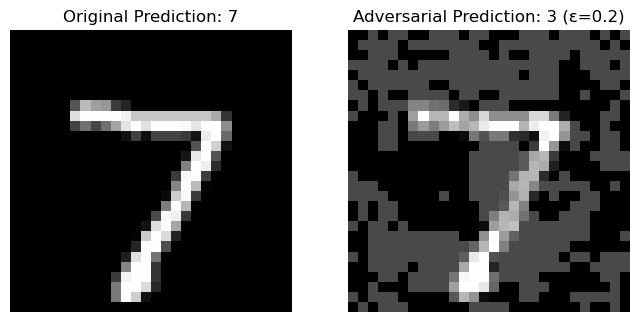

In [10]:
data, target = test_dataset[0]
data = data.to(device).unsqueeze(0) 
target = torch.tensor([target]).to(device)

model.eval()
with torch.no_grad():
    output = model(data)
original_pred = output.argmax(dim=1, keepdim=True).item()

epsilon = 0.2 
adv_data = fgsm_attack_one(model, data, target, epsilon)

with torch.no_grad():
    adv_output = model(adv_data)
adv_pred = adv_output.argmax(dim=1, keepdim=True).item()

original_img = data.cpu().squeeze().detach().numpy()
adv_img = adv_data.cpu().squeeze().detach().numpy()

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(original_img, cmap="gray")
ax[0].set_title(f"Original Prediction: {original_pred}")
ax[0].axis("off")

ax[1].imshow(adv_img, cmap="gray")
ax[1].set_title(f"Adversarial Prediction: {adv_pred} (ε={epsilon})")
ax[1].axis("off")

plt.show()

Train Epoch: 1 [0/60000] Loss: 2.140000
Train Epoch: 1 [6400/60000] Loss: 1.463288
Train Epoch: 1 [12800/60000] Loss: 1.463288
Train Epoch: 1 [19200/60000] Loss: 1.465426
Train Epoch: 1 [25600/60000] Loss: 1.483189
Train Epoch: 1 [32000/60000] Loss: 1.494199
Train Epoch: 1 [38400/60000] Loss: 1.476775
Train Epoch: 1 [44800/60000] Loss: 1.478574
Train Epoch: 1 [51200/60000] Loss: 1.478913
Train Epoch: 1 [57600/60000] Loss: 1.465426

Test set: Average loss: 0.0015, Accuracy: 9571/10000 (95.71%)

Train Epoch: 2 [0/60000] Loss: 1.463288
Train Epoch: 2 [6400/60000] Loss: 1.469445
Train Epoch: 2 [12800/60000] Loss: 1.465426
Train Epoch: 2 [19200/60000] Loss: 1.478913
Train Epoch: 2 [25600/60000] Loss: 1.465169
Train Epoch: 2 [32000/60000] Loss: 1.461150
Train Epoch: 2 [38400/60000] Loss: 1.465426
Train Epoch: 2 [44800/60000] Loss: 1.481051
Train Epoch: 2 [51200/60000] Loss: 1.465426
Train Epoch: 2 [57600/60000] Loss: 1.461150

Test set: Average loss: 0.0015, Accuracy: 9580/10000 (95.80%)

Tr

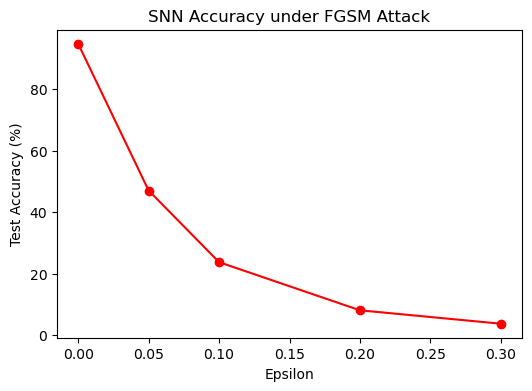

In [12]:
for epoch in range(1, 5):
    train(epoch)
    test()

epsilons = [0, 0.05, 0.1, 0.2, 0.3]
adversarial_accuracies = [test_adversarial(eps) for eps in epsilons]

plt.figure(figsize=(6, 4))
plt.plot(epsilons, adversarial_accuracies, marker='o', linestyle='-', color='r')
plt.xlabel('Epsilon')
plt.ylabel('Test Accuracy (%)')
plt.title('SNN Accuracy under FGSM Attack')
plt.show()

## Experiment 4: Spiking Neural Network (SNN) for Fashion MNIST with Adversarial attacks

Using device: cpu
Starting training...
Epoch [1/10], Loss: 1.6814, Train Acc: 68.19%, Val Acc: 74.55%
Epoch [2/10], Loss: 1.5968, Train Acc: 75.33%, Val Acc: 77.42%
Epoch [3/10], Loss: 1.5868, Train Acc: 76.06%, Val Acc: 74.76%
Epoch [4/10], Loss: 1.5810, Train Acc: 79.32%, Val Acc: 81.05%
Epoch [5/10], Loss: 1.5755, Train Acc: 81.36%, Val Acc: 77.97%
Epoch [6/10], Loss: 1.5730, Train Acc: 81.21%, Val Acc: 81.09%
Epoch [7/10], Loss: 1.5708, Train Acc: 81.76%, Val Acc: 81.52%
Epoch [8/10], Loss: 1.5719, Train Acc: 81.41%, Val Acc: 83.46%
Epoch [9/10], Loss: 1.5709, Train Acc: 82.27%, Val Acc: 82.97%
Epoch [10/10], Loss: 1.5652, Train Acc: 83.39%, Val Acc: 83.47%
Clean Test Accuracy (no attack): 82.45%
Epsilon: 0.0000, Test Accuracy: 82.45%
Epsilon: 0.0100, Test Accuracy: 77.97%
Epsilon: 0.0200, Test Accuracy: 72.89%
Epsilon: 0.0300, Test Accuracy: 67.61%
Epsilon: 0.0500, Test Accuracy: 58.22%
Epsilon: 0.1000, Test Accuracy: 35.70%
Epsilon: 0.2000, Test Accuracy: 14.41%
Epsilon: 0.3000, 

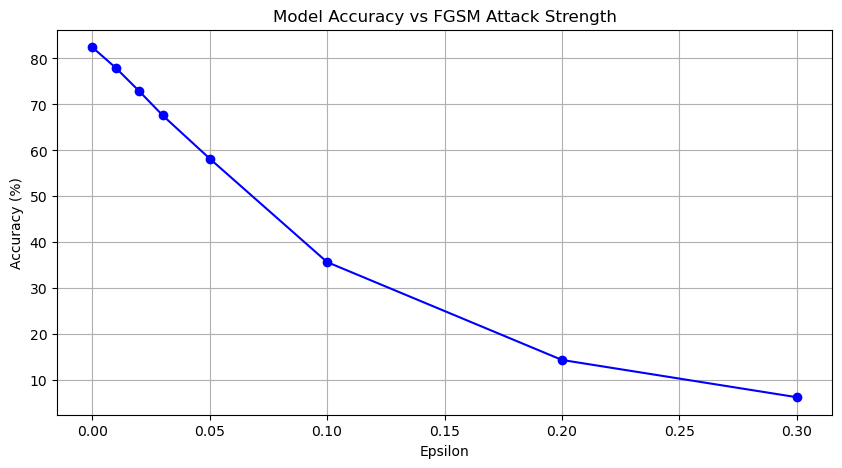

In [1]:
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import surrogate, utils
from snntorch import functional as SF
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

batch_size = 128
num_epochs = 10
learning_rate = 0.001
num_steps = 25
beta = 0.95
spike_grad = surrogate.fast_sigmoid()

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class SNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc2 = nn.Linear(512, 256)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc3 = nn.Linear(256, 10)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        
    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        
        spk3_rec = []
        
        x = x.view(-1, 28*28)
        
        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)
            spk3_rec.append(spk3)
        
        return torch.stack(spk3_rec, dim=0)

model = SNNModel().to(device)

criterion = SF.ce_rate_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print("Starting training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        spk_rec = model(images)
        
        loss = criterion(spk_rec, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(spk_rec.sum(dim=0), 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            spk_rec = model(images)
            _, predicted = torch.max(spk_rec.sum(dim=0), 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_acc = 100 * val_correct / val_total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

def fgsm_attack(model, data, target, epsilon):
    data.requires_grad = True
    
    spk_rec = model(data)
    loss = criterion(spk_rec, target)
    
    model.zero_grad()
    
    loss.backward()
    
    data_grad = data.grad.data
    sign_data_grad = data_grad.sign()
    
    perturbed_data = data + epsilon * sign_data_grad
    
    perturbed_data = torch.clamp(perturbed_data, 0, 1)
    
    return perturbed_data

def test_with_fgsm(model, test_loader, epsilon):
    correct = 0
    total = 0
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        perturbed_data = fgsm_attack(model, images, labels, epsilon)
        
        with torch.no_grad():
            spk_rec = model(perturbed_data)
            _, predicted = torch.max(spk_rec.sum(dim=0), 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Epsilon: {epsilon:.4f}, Test Accuracy: {accuracy:.2f}%')
    return accuracy

model.eval()
clean_correct = 0
clean_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        spk_rec = model(images)
        _, predicted = torch.max(spk_rec.sum(dim=0), 1)
        clean_total += labels.size(0)
        clean_correct += (predicted == labels).sum().item()

clean_accuracy = 100 * clean_correct / clean_total
print(f'Clean Test Accuracy (no attack): {clean_accuracy:.2f}%')

epsilons = [0, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3]
accuracies = []

for eps in epsilons:
    acc = test_with_fgsm(model, test_loader, eps)
    accuracies.append(acc)

plt.figure(figsize=(10, 5))
plt.plot(epsilons, accuracies, 'bo-')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy vs FGSM Attack Strength')
plt.grid()
plt.show()

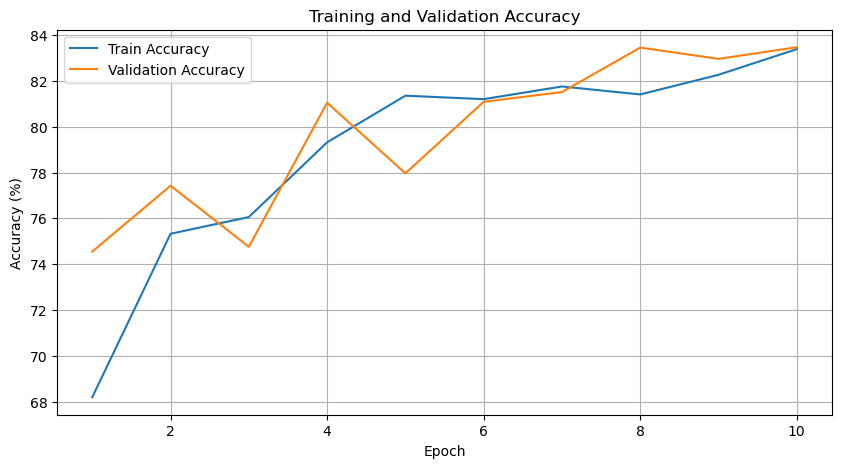

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_acc_history, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [2]:
torch.save(model.state_dict(), 'mnist_snn.pth')

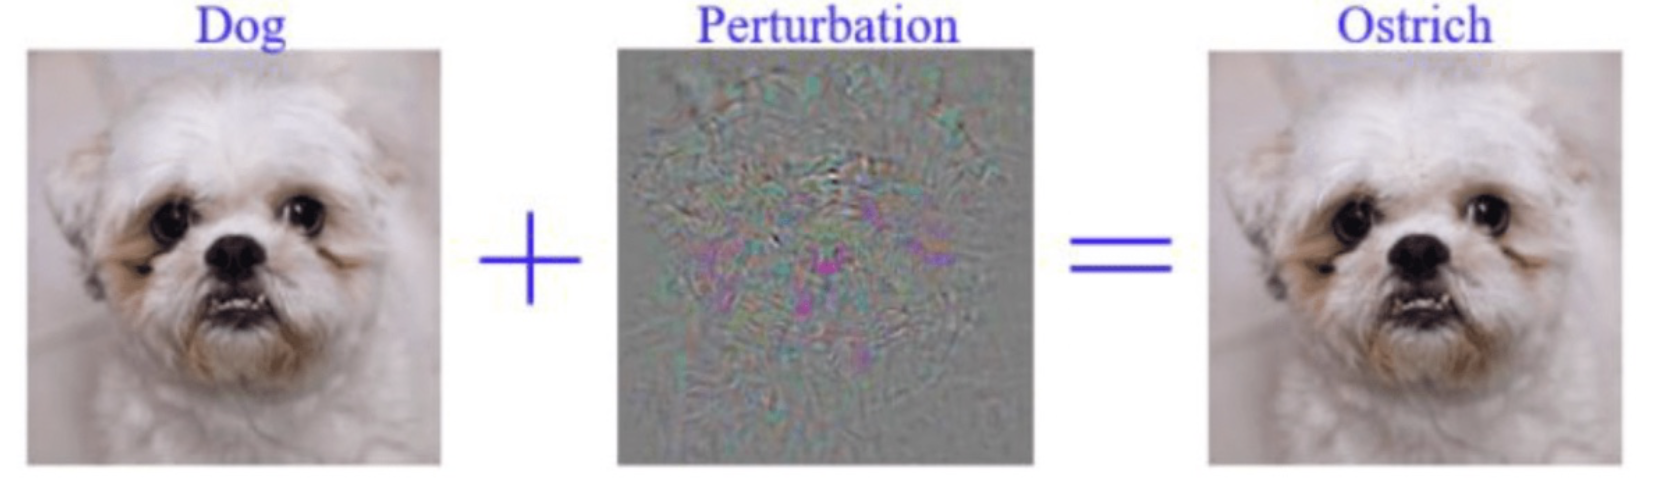
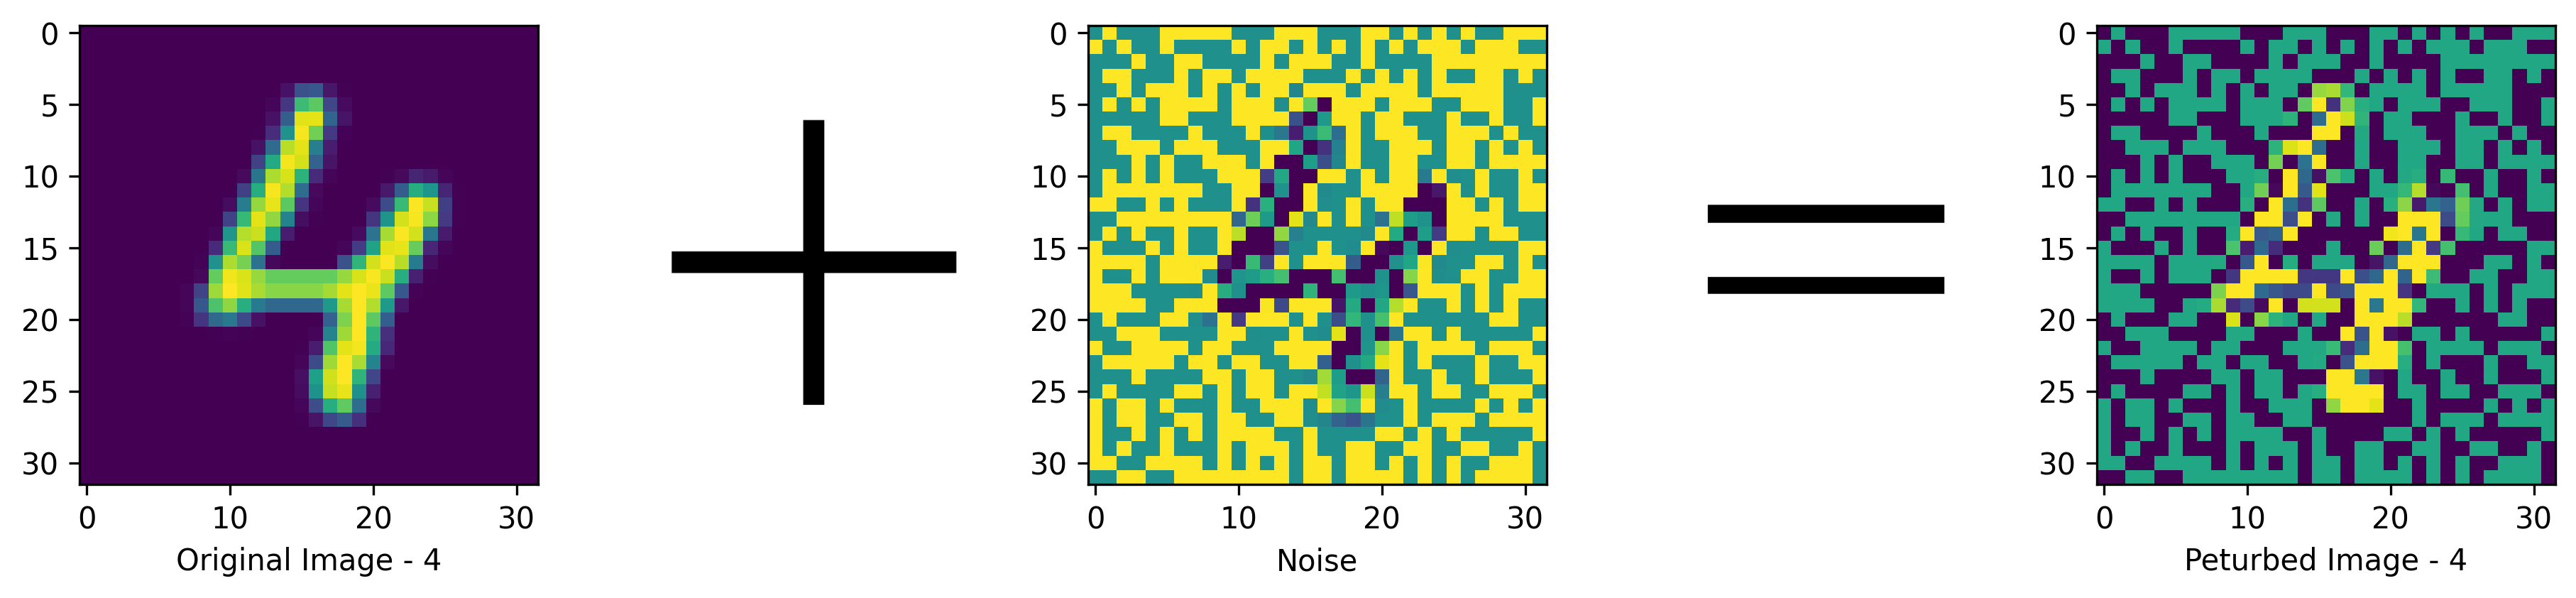
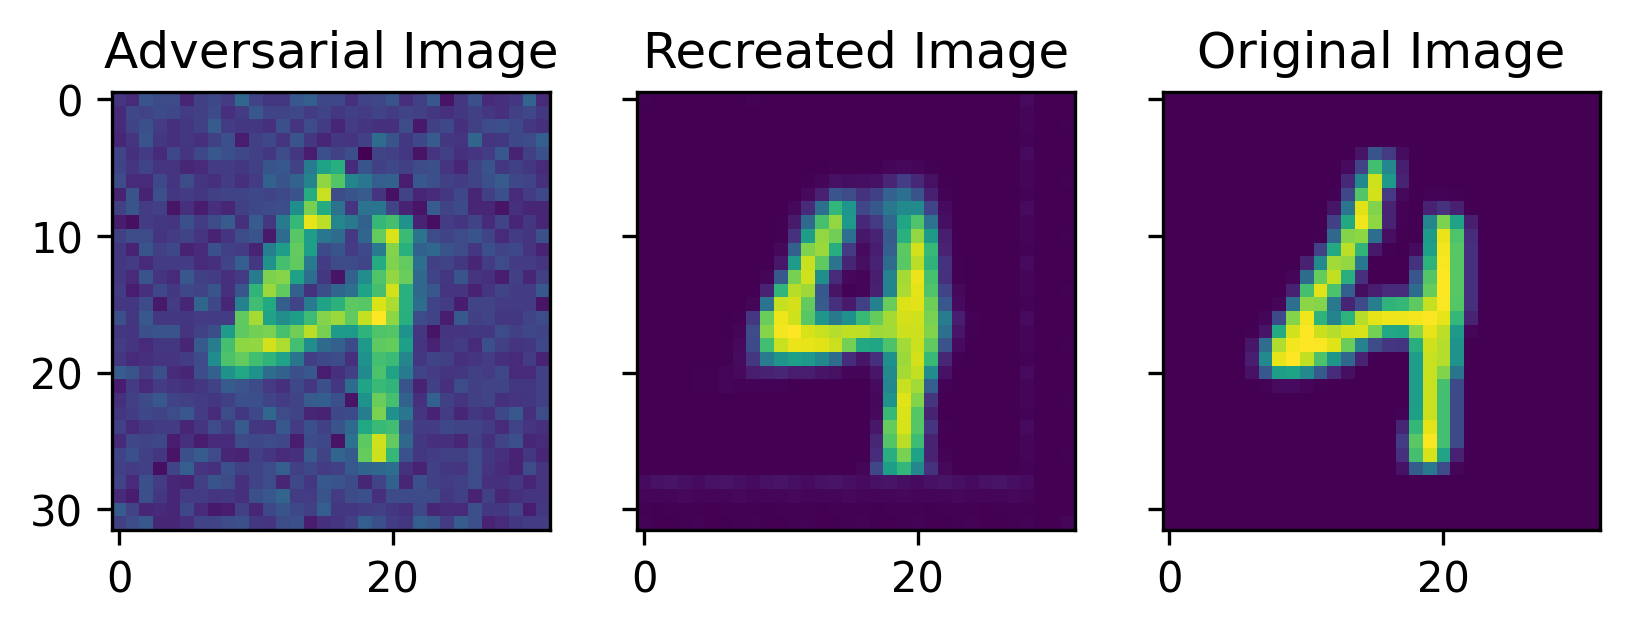

## SNN model Architecture

Feedforward Structure: <br>
Input: 784 dimensions (28×28 flattened Fashion MNIST images)<br>
Hidden Layer 1: 512 neurons<br>
Hidden Layer 2: 256 neurons<br>
Output Layer: 10 neurons (one per Fashion MNIST class)<br>
Neuron Model:<br>
Leaky Integrate-and-Fire (LIF) neurons<br>
Configured with:<br>
beta: Decay rate (0.95 in our case)<br>
spike_grad: Surrogate gradient (fast sigmoid) for backpropagation<br>
Temporal Dynamics:<br>
Processes inputs over num_steps=25 time steps<br>
Maintains membrane potentials (mem1, mem2, mem3) between time steps<br>

## Experiment 5: Training an autoencoder to reconstruction clean images, which used to remove adversarial noise

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import snntorch as snn
from snntorch import surrogate, functional
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

batch_size = 128
num_steps = 25
beta = 0.95
learning_rate = 1e-3
num_epochs = 10
#epsilon = 0.3  

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
       
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
       
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class SNNModel(nn.Module):
    def __init__(self):
        super(SNNModel, self).__init__()
        
        spike_grad = surrogate.fast_sigmoid()
        
        self.fc1 = nn.Linear(28*28, 512)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        
        self.fc2 = nn.Linear(512, 256)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        
        self.fc3 = nn.Linear(256, 10)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad, output=True)
        
    def forward(self, x, num_steps):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        
        spk3_rec = []
        mem3_rec = []
        
        x = x.view(-1, 28*28)
        
        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            
            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)
            
            spk3_rec.append(spk3)
            mem3_rec.append(mem3)
        
        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)

Using device: cpu


In [2]:
autoencoder = Autoencoder().to(device)
snn_model = SNNModel().to(device)

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

ae_optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
snn_optimizer = optim.Adam(snn_model.parameters(), lr=learning_rate)

print("Training Autoencoder...")
for epoch in range(5):
    for data, _ in tqdm(train_loader, desc=f"AE Epoch {epoch+1}"):
        data = data.to(device)
        
        noise = torch.randn_like(data) * 0.1
        noisy_data = data + noise
        
        reconstructed = autoencoder(noisy_data)
        
        loss = mse_loss(reconstructed, data)
        
        ae_optimizer.zero_grad()
        loss.backward()
        ae_optimizer.step()

Training Autoencoder...


AE Epoch 5: 100%|█████████████████████████████████████████████████| 469/469 [00:16<00:00, 27.87it/s]


In [3]:
print("\nTraining SNN Model...")
for epoch in range(num_epochs):
    snn_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for data, targets in tqdm(train_loader, desc=f"SNN Epoch {epoch+1}"):
        data, targets = data.to(device), targets.to(device)
        
        spk_rec, mem_rec = snn_model(data, num_steps)
        
        loss = ce_loss(mem_rec.sum(dim=0), targets)
        
        snn_optimizer.zero_grad()
        loss.backward()
        snn_optimizer.step()
        
        _, predicted = mem_rec.sum(dim=0).max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        running_loss += loss.item()
    
    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    
    snn_model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            
            spk_rec, mem_rec = snn_model(data, num_steps)
            
            loss = ce_loss(mem_rec.sum(dim=0), targets)
            test_loss += loss.item()
            
            _, predicted = mem_rec.sum(dim=0).max(1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    test_acc = 100 * correct / total
    test_loss = test_loss / len(test_loader)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")


Training SNN Model...


SNN Epoch 1: 100%|████████████████████████████████████████████████| 469/469 [00:17<00:00, 26.82it/s]


Epoch 1/10, Train Loss: 0.8114, Train Acc: 77.28%, Test Loss: 0.4932, Test Acc: 82.63%


SNN Epoch 2: 100%|████████████████████████████████████████████████| 469/469 [00:18<00:00, 25.57it/s]


Epoch 2/10, Train Loss: 0.4940, Train Acc: 82.70%, Test Loss: 0.4739, Test Acc: 83.82%


SNN Epoch 3: 100%|████████████████████████████████████████████████| 469/469 [00:18<00:00, 24.82it/s]


Epoch 3/10, Train Loss: 0.4487, Train Acc: 84.00%, Test Loss: 0.6180, Test Acc: 80.32%


SNN Epoch 4: 100%|████████████████████████████████████████████████| 469/469 [00:19<00:00, 24.45it/s]


Epoch 4/10, Train Loss: 0.4334, Train Acc: 84.65%, Test Loss: 0.4607, Test Acc: 83.73%


SNN Epoch 5: 100%|████████████████████████████████████████████████| 469/469 [00:19<00:00, 24.44it/s]


Epoch 5/10, Train Loss: 0.4380, Train Acc: 84.40%, Test Loss: 0.4963, Test Acc: 83.05%


SNN Epoch 6: 100%|████████████████████████████████████████████████| 469/469 [00:19<00:00, 24.10it/s]


Epoch 6/10, Train Loss: 0.4448, Train Acc: 84.42%, Test Loss: 0.4713, Test Acc: 83.53%


SNN Epoch 7: 100%|████████████████████████████████████████████████| 469/469 [00:19<00:00, 24.14it/s]


Epoch 7/10, Train Loss: 0.4419, Train Acc: 84.30%, Test Loss: 0.4477, Test Acc: 83.90%


SNN Epoch 8: 100%|████████████████████████████████████████████████| 469/469 [00:19<00:00, 24.10it/s]


Epoch 8/10, Train Loss: 0.4344, Train Acc: 84.67%, Test Loss: 0.4927, Test Acc: 83.06%


SNN Epoch 9: 100%|████████████████████████████████████████████████| 469/469 [00:19<00:00, 23.90it/s]


Epoch 9/10, Train Loss: 0.4286, Train Acc: 85.11%, Test Loss: 0.4912, Test Acc: 82.78%


SNN Epoch 10: 100%|███████████████████████████████████████████████| 469/469 [00:19<00:00, 24.01it/s]


Epoch 10/10, Train Loss: 0.4339, Train Acc: 84.63%, Test Loss: 0.4889, Test Acc: 83.00%


In [9]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, -1, 1)
    return perturbed_image

def test_with_defense(model, autoencoder, test_loader, epsilon):
    correct = 0
    total = 0
    
    for data, targets in tqdm(test_loader, desc="Testing with Defense"):
        data, targets = data.to(device), targets.to(device)
        
        data.requires_grad = True
        
        spk_rec, mem_rec = model(data, num_steps)
        loss = ce_loss(mem_rec.sum(dim=0), targets)
        
        model.zero_grad()
        
        loss.backward()
        
        data_grad = data.grad.data
        
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        
        with torch.no_grad():
            denoised_data = autoencoder(perturbed_data)
        
        with torch.no_grad():
            spk_rec, mem_rec = model(denoised_data, num_steps)
            _, predicted = mem_rec.sum(dim=0).max(1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Accuracy on adversarial examples (epsilon={epsilon}) with denoising: {accuracy:.2f}%")
    return accuracy


Testing adversarial defense...


Testing with Defense: 100%|█████████████████████████████████████████| 79/79 [00:05<00:00, 13.84it/s]


Accuracy on adversarial examples (epsilon=0) with denoising: 81.93%


Testing with Defense: 100%|█████████████████████████████████████████| 79/79 [00:05<00:00, 14.26it/s]


Accuracy on adversarial examples (epsilon=0.01) with denoising: 80.57%


Testing with Defense: 100%|█████████████████████████████████████████| 79/79 [00:05<00:00, 14.32it/s]


Accuracy on adversarial examples (epsilon=0.02) with denoising: 79.29%


Testing with Defense: 100%|█████████████████████████████████████████| 79/79 [00:05<00:00, 13.94it/s]


Accuracy on adversarial examples (epsilon=0.03) with denoising: 77.88%


Testing with Defense: 100%|█████████████████████████████████████████| 79/79 [00:05<00:00, 14.21it/s]


Accuracy on adversarial examples (epsilon=0.05) with denoising: 75.20%


Testing with Defense: 100%|█████████████████████████████████████████| 79/79 [00:05<00:00, 13.94it/s]


Accuracy on adversarial examples (epsilon=0.1) with denoising: 69.11%


Testing with Defense: 100%|█████████████████████████████████████████| 79/79 [00:05<00:00, 14.23it/s]


Accuracy on adversarial examples (epsilon=0.2) with denoising: 60.57%


Testing with Defense: 100%|█████████████████████████████████████████| 79/79 [00:05<00:00, 14.19it/s]


Accuracy on adversarial examples (epsilon=0.3) with denoising: 52.33%


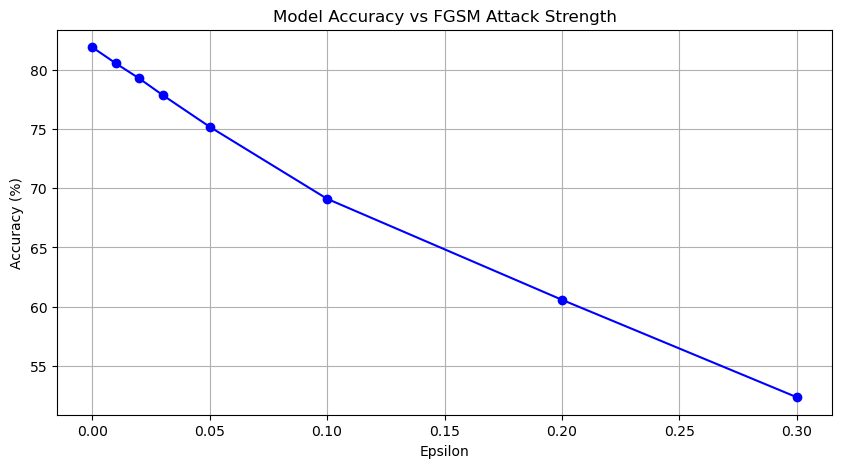

In [11]:
print("\nTesting adversarial defense...")

epsilons = [0, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3]
accuracies = []

for eps in epsilons:
    acc = test_with_defense(snn_model, autoencoder, test_loader, eps)
    accuracies.append(acc)

plt.figure(figsize=(10, 5))
plt.plot(epsilons, accuracies, 'bo-')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy vs FGSM Attack Strength')
plt.grid()
plt.show()

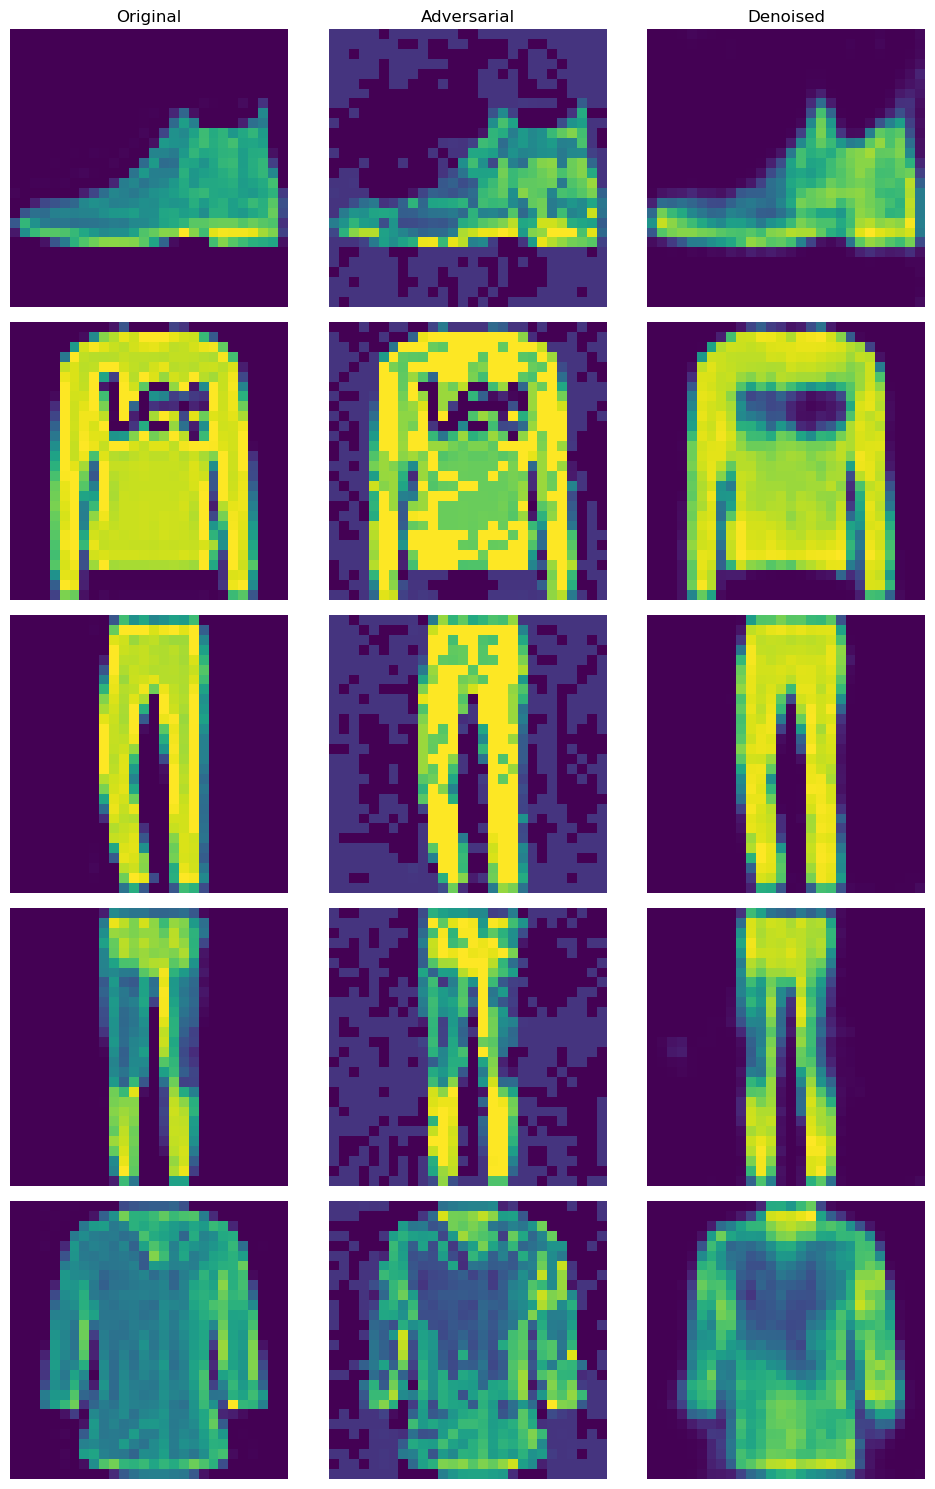

In [8]:
def visualize_examples(autoencoder, test_loader, epsilon):
    data, _ = next(iter(test_loader))
    data = data[:5].to(device)
    
    data.requires_grad = True
    spk_rec, mem_rec = snn_model(data, num_steps)
    loss = ce_loss(mem_rec.sum(dim=0), torch.zeros(5, dtype=torch.long).to(device))
    snn_model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    perturbed_data = fgsm_attack(data, epsilon, data_grad)
    
    # Denoise
    with torch.no_grad():
        denoised_data = autoencoder(perturbed_data)
    

    fig, axes = plt.subplots(5, 3, figsize=(10, 15))
    titles = ['Original', 'Adversarial', 'Denoised']
    
    for i in range(5):
        for j, img in enumerate([data[i], perturbed_data[i], denoised_data[i]]):
            img = img.squeeze().cpu().detach().numpy()
            axes[i,j].imshow(img, cmap='viridis')
            axes[i,j].set_title(titles[j] if i == 0 else "")
            axes[i,j].axis('off')
    
    plt.tight_layout()
    plt.show()
visualize_examples(autoencoder, test_loader, epsilon)

## Experiment 6: use Animal Face dataset 

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets
from torch.utils.data import random_split, Subset
import random
from spikingjelly.clock_driven import neuron, encoding, functional, surrogate, layer

In [4]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])
random.seed(42)

full_dataset = datasets.ImageFolder(root='data/AnimalFace/train', transform=transform)

total_size = len(full_dataset)
subset_size = total_size // 5
subset_indices = random.sample(range(total_size), subset_size)
subset = Subset(full_dataset, subset_indices)

train_size = int(0.8 * subset_size)
test_size = subset_size - train_size
train_set, test_set = random_split(subset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
from torchvision.models import resnet18
class SpikingResNet18(nn.Module):
    def __init__(self, T=4, num_classes=3):
        super().__init__()
        self.T = T 
        self.num_classes = num_classes
        
        self.base = resnet18(weights=None)
        
        self._convert_to_spiking()
        
        self.base.fc = nn.Linear(self.base.fc.in_features, num_classes)
        
    def _convert_to_spiking(self):
        """Replace ReLU layers with LIF neurons"""
        for name, module in self.base.named_children():
            if isinstance(module, nn.ReLU):
                setattr(self.base, name, neuron.LIFNode(
                    tau=2.0, 
                    surrogate_function=surrogate.Sigmoid(),
                    detach_reset=True
                ))
            elif isinstance(module, nn.Sequential):
                for block_name, block_module in module.named_children():
                    for layer_name, layer_module in block_module.named_children():
                        if isinstance(layer_module, nn.ReLU):
                            setattr(block_module, layer_name, neuron.LIFNode(
                                tau=2.0,
                                surrogate_function=surrogate.ATan(),
                                detach_reset=True
                            ))
    
    def forward(self, x):
        batch_size = x.shape[0]
        x_seq = torch.zeros((self.T, batch_size, self.num_classes)).to(x.device)
        
        functional.reset_net(self.base)
        
        for t in range(self.T):
            out = self.base(x)
            x_seq[t] = out
        out = x_seq.mean(0)
        
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpikingResNet18(T=4, num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [7]:
for epoch in range(30):  # Use more for better accuracy
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {running_loss:.4f}")



Epoch 1 - Loss: 307.5843
Epoch 2 - Loss: 293.4561
Epoch 3 - Loss: 274.1488
Epoch 4 - Loss: 263.4696
Epoch 5 - Loss: 257.0028
Epoch 6 - Loss: 242.5488
Epoch 7 - Loss: 235.9424
Epoch 8 - Loss: 225.6230
Epoch 9 - Loss: 219.5720
Epoch 10 - Loss: 210.1144
Epoch 11 - Loss: 188.2659
Epoch 12 - Loss: 180.8798
Epoch 13 - Loss: 158.1835
Epoch 14 - Loss: 139.2659
Epoch 15 - Loss: 117.5981
Epoch 16 - Loss: 109.1799
Epoch 17 - Loss: 92.6473
Epoch 18 - Loss: 93.9586
Epoch 19 - Loss: 88.1189
Epoch 20 - Loss: 74.6857
Epoch 21 - Loss: 74.7961
Epoch 22 - Loss: 62.6821
Epoch 23 - Loss: 62.4463
Epoch 24 - Loss: 61.3611
Epoch 25 - Loss: 49.5827
Epoch 26 - Loss: 54.1464
Epoch 27 - Loss: 45.0635
Epoch 28 - Loss: 38.4006
Epoch 29 - Loss: 43.6726
Epoch 30 - Loss: 37.4692


In [8]:
def test_accuracy(loader, model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total

clean_acc = test_accuracy(test_loader, model)
print("Accuracy on clean images:", clean_acc)

Accuracy on clean images: 0.9010238907849829


In [9]:
def fgsm_attack(model, images, labels, epsilon):
    images = images.clone().detach().to(device).requires_grad_(True)
    model.eval()
    outputs = model(images)
    loss = criterion(outputs, labels)
    model.zero_grad()
    loss.backward()
    data_grad = images.grad.data
    perturbed_images = images + epsilon * data_grad.sign()
    perturbed_images = torch.clamp(perturbed_images, 0, 1)
    return perturbed_images

epsilons = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
adv_accuracies = []

for eps in epsilons:
    total, correct = 0, 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        perturbed = fgsm_attack(model, inputs, labels, eps)
        outputs = model(perturbed)
        _, pred = outputs.max(1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)
    acc = correct / total
    adv_accuracies.append(acc)
    print(f"Epsilon: {eps} - Accuracy: {acc}")

Epsilon: 0.1 - Accuracy: 0.2098976109215017
Epsilon: 0.2 - Accuracy: 0.13993174061433447
Epsilon: 0.3 - Accuracy: 0.1075085324232082
Epsilon: 0.4 - Accuracy: 0.11433447098976109
Epsilon: 0.5 - Accuracy: 0.11433447098976109
Epsilon: 0.6 - Accuracy: 0.11945392491467577


In [ ]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(128, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(64, 3, 3, stride=1, padding=1),
            nn.Sigmoid()
        )
        
        self.attention = nn.Sequential(
            nn.Conv2d(256, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        enc1 = self.encoder[:3](x)
        enc2 = self.encoder[3:6](enc1)
        enc3 = self.encoder[6:9](enc2)
        enc4 = self.encoder[9:12](enc3)
        enc5 = self.encoder[12:](enc4)
        
        attention = self.attention(enc5)
        enc5 = enc5 * attention
        
        dec1 = self.decoder[:3](enc5) + enc4
        dec2 = self.decoder[3:6](dec1) + enc3
        dec3 = self.decoder[6:9](dec2) + enc2
        dec4 = self.decoder[9:12](dec3) + enc1
        dec5 = self.decoder[12:](dec4)
        
        return dec5

autoencoder = DenoisingAutoencoder().to(device)
ae_optimizer = optim.AdamW(autoencoder.parameters(), lr=1e-4, weight_decay=1e-5)
ae_loss = nn.MSELoss()

vgg = torchvision.models.vgg16(pretrained=True).features[:16].to(device).eval()
for param in vgg.parameters():
    param.requires_grad = False

def perceptual_loss(input, target):
    input_features = vgg(input)
    target_features = vgg(target)
    return F.mse_loss(input_features, target_features)

def train_ae(autoencoder, noisy_imgs, clean_imgs, optimizer):
    autoencoder.train()
    optimizer.zero_grad()
    
    reconstructed = autoencoder(noisy_imgs)
    
    mse_loss = ae_loss(reconstructed, clean_imgs)
    percep_loss = perceptual_loss(reconstructed, clean_imgs)
    total_loss = 0.7*mse_loss + 0.3*percep_loss
    
    total_loss.backward()
    optimizer.step()
    return total_loss.item()

In [11]:
for epoch in range(5):
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        adv = fgsm_attack(model, inputs, labels, epsilon=0.3)
        recon = autoencoder(adv)
        loss = ae_loss(recon, inputs)
        ae_optimizer.zero_grad()
        loss.backward()
        ae_optimizer.step()
    print(f"AE Epoch {epoch+1} done")

AE Epoch 1 done
AE Epoch 2 done
AE Epoch 3 done
AE Epoch 4 done
AE Epoch 5 done


In [14]:
def test_denoised_accuracy(eps):
    model.eval()
    autoencoder.eval()
    correct = 0
    total = 0

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        adv_inputs = fgsm_attack(model, inputs, labels, eps)

        with torch.no_grad():  
            denoised = autoencoder(adv_inputs)
            outputs = model(denoised)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    print(f"Denoised Accuracy (eps={eps}):", correct / (total))

test_denoised_accuracy(0.15)

Denoised Accuracy (eps=0.15): 0.764505119453925


In [17]:
test_denoised_accuracy(0.06)

Denoised Accuracy (eps=0.06): 0.7849829351535836


In [18]:
test_denoised_accuracy(0.6)

Denoised Accuracy (eps=0.6): 0.2593856655290102


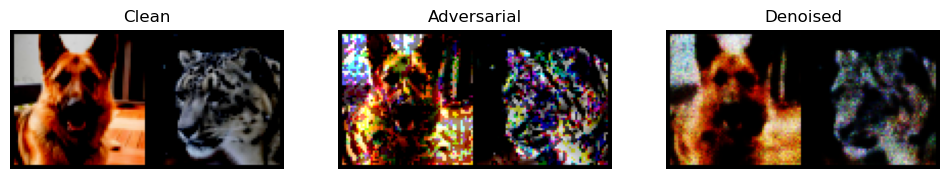

In [15]:
import torchvision
def imshow(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)
adv = fgsm_attack(model, images, labels.to(device), 0.3)
denoised = autoencoder(adv)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
imshow(torchvision.utils.make_grid(images[:2]))
plt.title('Clean')

plt.subplot(1, 3, 2)
imshow(torchvision.utils.make_grid(adv[:2]))
plt.title('Adversarial')

plt.subplot(1, 3, 3)
imshow(torchvision.utils.make_grid(denoised[:2]))
plt.title('Denoised')
plt.show()